# Video Codec

In this project, we're going to implement a simple codec for a video.

## Import Libraries

First of all, we need to import the neccessary modules e.g. OpenCV and Numpy.

In [44]:
import cv2
import numpy as np

## Capture video

Then we use OpenCV for capturing the mentioned video. we extract it's frame one by one, store each in a list named gray_frames. it's important to say that we'll work with GRAY frames(not colored oens).

In [45]:
cap = cv2.VideoCapture('sample 30 frame 1 min.mp4')
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

gray_frames = []    
while(cap.isOpened()):
  
    ret, frame = cap.read()
    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frames.append(gray)
        cv2.imshow('Frame', gray)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break

cap.release()
cv2.destroyAllWindows()

## Preprocessing(Padding)

Since we're going to work with 8 * 8 blocks in each frame, we need to have frames with dimensions multiples of 8 or if not, we need to make their dimensions multiples of 8! So we'll pad the frames to reach this goal.

In [46]:
for i in range(len(gray_frames)):
    current_gray_frame = gray_frames[i]
    gray_frames[i] = cv2.copyMakeBorder(current_gray_frame, 2, 2, 0, 0, cv2.BORDER_REPLICATE) 
    

In [47]:
print(gray_frames[0].shape)

(544, 960)


## Encoder

### DCT

Now we're ready for doing Discrete Cosine Transform or DCT. we iterate over all the frames, and in each frame, we apply DCT on 8 * 8 blocks of the frame. we stroe transformed frames in a list called transformed_frames.

In [50]:
block_width = 8
block_height = 8

num_frames = len(gray_frames)
transformed_frames = []

print('First gray frame: ')
print(gray_frames[0])
print()

for f in range(num_frames):
    current_frame = gray_frames[f]
    current_frame_transformed = np.empty_like(current_frame, dtype=np.float32)
    frame_height, frame_width = current_frame.shape
    
    for i in range(0, frame_height, block_height):
        for j in range(0, frame_width, block_width):
            current_block = np.array(current_frame[i: i + block_height, j: j + block_width], dtype=np.float32)
            transformed_current_block = cv2.dct(current_block)
#             transformed_current_block = dct(dct(current_block, axis=0, norm="ortho"), axis=1, norm="ortho")
            current_frame_transformed[i: i + block_height, j: j + block_width] = transformed_current_block
    transformed_frames.append(current_frame_transformed)

print('First transformed frame: ')
print(transformed_frames[0])
print()

First gray frame: 
[[ 59  96 118 ... 141 108  65]
 [ 59  96 118 ... 141 108  65]
 [ 59  96 118 ... 141 108  65]
 ...
 [ 53  93 123 ... 124 102  65]
 [ 53  93 123 ... 124 102  65]
 [ 53  93 123 ... 124 102  65]]

First transformed frame: 
[[ 9.78500000e+02 -1.28162231e+02 -9.96509781e+01 ...  1.32814989e+01
   6.01861477e+00 -5.92755747e+00]
 [-7.39637909e+01  1.06848631e+01  8.67744637e+00 ... -2.58376837e+00
   3.03968978e+00 -1.70750749e+00]
 [-2.56925335e+01  1.61831472e-02  1.20710373e+00 ...  4.44632113e-01
  -1.93566024e+00  2.10769010e+00]
 ...
 [-7.33876896e+00 -1.23907775e-01 -1.14798880e+00 ... -7.12391138e-01
  -1.37865022e-01  6.67120874e-01]
 [-1.16337261e+01  1.14310287e-01 -8.16941798e-01 ... -6.35443389e-01
  -6.69417381e-02  6.30997360e-01]
 [ 1.21543274e+01 -2.09117651e+00 -4.64548498e-01 ...  6.24508858e-01
   8.17221925e-02 -5.42408943e-01]]



### Quantization

In [42]:
transformed_frames = [np.abs(transformed_frames[i]).astype(np.uint64) for i in range(len(transformed_frames))]

In [43]:
transformed_frames[0]

array([[978, 128,  99, ...,  13,   6,   5],
       [ 73,  10,   8, ...,   2,   3,   1],
       [ 25,   0,   1, ...,   0,   1,   2],
       ...,
       [  7,   0,   1, ...,   0,   0,   0],
       [ 11,   0,   0, ...,   0,   0,   0],
       [ 12,   2,   0, ...,   0,   0,   0]], dtype=uint64)

In [ ]:
for f in range(num_frames):
    current_frame = transformed_frames[f]
    current_frame_transformed = np.empty_like(current_frame, dtype=np.float32)
    frame_height, frame_width = current_frame.shape
    
    for i in range(0, frame_height, block_height):
        for j in range(0, frame_width, block_width):
            current_block = np.array(current_frame[i: i + block_height, j: j + block_width], dtype=np.float32)
            transformed_current_block = cv2.dct(current_block)
#             transformed_current_block = dct(dct(current_block, axis=0, norm="ortho"), axis=1, norm="ortho")
            current_frame_transformed[i: i + block_height, j: j + block_width] = transformed_current_block
    transformed_frames.append(current_frame_transformed)

In [22]:
blocksV= gray_frames[0].shape[0]//block_height
blocksH= gray_frames[0].shape[1]//block_width
print(blocksV)
print(blocksH)
vis0 = np.zeros((gray_frames[0].shape[0], gray_frames[0].shape[1]), np.float32)
Trans = np.zeros((gray_frames[0].shape[0], gray_frames[0].shape[1]), np.float32)
vis0[:gray_frames[0].shape[0], :gray_frames[0].shape[1]] = gray_frames[0]

for row in range(blocksV):
        for col in range(blocksH):
                currentblock = cv2.dct(vis0[row*block_height:(row+1)*block_height, col*block_height:(col+1)*block_height])
                Trans[row*block_height:(row+1)*block_height, col*block_height:(col+1)*block_height]=currentblock
cv2.imwrite('Transformed.jpg', Trans)

68
120


True

In [31]:
print(Trans)

[[ 9.78500000e+02 -1.28162231e+02 -9.96509781e+01 ...  1.32814989e+01
   6.01861477e+00 -5.92755747e+00]
 [-7.39637909e+01  1.06848631e+01  8.67744637e+00 ... -2.58376837e+00
   3.03968978e+00 -1.70750749e+00]
 [-2.56925335e+01  1.61831472e-02  1.20710373e+00 ...  4.44632113e-01
  -1.93566024e+00  2.10769010e+00]
 ...
 [-7.33876896e+00 -1.23907775e-01 -1.14798880e+00 ... -7.12391138e-01
  -1.37865022e-01  6.67120874e-01]
 [-1.16337261e+01  1.14310287e-01 -8.16941798e-01 ... -6.35443389e-01
  -6.69417381e-02  6.30997360e-01]
 [ 1.21543274e+01 -2.09117651e+00 -4.64548498e-01 ...  6.24508858e-01
   8.17221925e-02 -5.42408943e-01]]


Text(0.5, 1.0, 'DCT transform of selected Region')

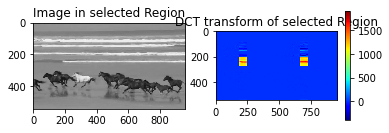

In [32]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
B=8
plt.figure()
plt.subplot(1,2,1)
img = gray_frames[0]
# selectedImg= img[row*B:(row+1)*B,col*B:(col+1)*B]
selectedImg= img
N255=Normalize(0,255) #Normalization object, used by imshow()
plt.imshow(selectedImg,cmap="gray",norm=N255,interpolation='nearest')
plt.title("Image in selected Region")

plt.subplot(1,2,2)
# selectedTrans=Trans[row*B:(row+1)*B,col*B:(col+1)*B]
selectedTrans=Trans
plt.imshow(selectedTrans,cmap=cm.jet,interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title("DCT transform of selected Region")

# Resources & References

1. https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/
2. https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html
3. https://ottverse.com/discrete-cosine-transform-dct-video-compression/
4. https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/
5. https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html#scipy.fftpack.dct
6. https://docs.scipy.org/doc/scipy/reference/fftpack.html
7. https://fairyonice.github.io/2D-DCT.html
8. https://www.geeksforgeeks.org/python-opencv-cv2-copymakeborder-method/
9. https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/transforms.html